# Zillow machine learning algorithm

This project aims to predict zillow housing price estimates. It will utilize the pandas and Scikit-learn packages from python 3.6 to attempt to create a better algorithm than Zillow already has implemented. The data was distributed from Zillow via kaggle.com 

main packages: Pandas, numpy, Sklearn, and matplotlib

In [1]:
#time script
from datetime import datetime
startTime = datetime.now()

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from time import time
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
raw_results=pd.read_csv('C:/Users/Will/Documents/Regis/MSDS692/train_2016_v2.csv/train_2016_v2.csv')
raw_properties=pd.read_csv('C:/Users/Will/Documents/Regis/MSDS692/properties_2016.csv/properties_2016.csv',low_memory=False)

In [4]:
raw_properties_combined=raw_properties.merge(raw_results,how='inner',on='parcelid')
print(len(raw_properties))

2985217


## Feature engineering for training  
Will extract month from transaction date to use for training, saw some improvement with this feature.

In [5]:
dates=pd.to_datetime(raw_properties_combined['transactiondate'])
#dates.head(n=5)
raw_properties_combined['Month']=dates.dt.month

## Model type

The zillow model is defined as the log of the zillow estimate to the log of the actual sale price, the competition is to determine what the computed error will be. This can be seen below. An initial challenge of this project is that the sale date can not be used as an input, where a forecasted multiplier might be useful, however the date of transactions is useful. The training data set contains 90K transactions, for model testing this will be broken into a random sample based on a 70:30 split.

In [6]:
raw_results.head(n=5)
len(raw_results)

90275

In [7]:
raw_properties.head(n=5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


## Data Set Initial Challenges

Many features are missing for most of the properties. The first attempt at this model will be to remove any feature which does not have at least 90% of the values. Some imputation will be attempted on those values, and then depending on the outcome more of the low count observations will be removed. 

In [8]:
raw_properties_combined.isnull().sum()/len(raw_properties_combined)

parcelid                        0.000000
airconditioningtypeid           0.681185
architecturalstyletypeid        0.997109
basementsqft                    0.999524
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingclasstypeid             0.999823
buildingqualitytypeid           0.364564
calculatedbathnbr               0.013093
decktypeid                      0.992711
finishedfloor1squarefeet        0.924054
calculatedfinishedsquarefeet    0.007322
finishedsquarefeet12            0.051831
finishedsquarefeet13            0.999634
finishedsquarefeet15            0.960521
finishedsquarefeet50            0.924054
finishedsquarefeet6             0.995336
fips                            0.000000
fireplacecnt                    0.893581
fullbathcnt                     0.013093
garagecarcnt                    0.668380
garagetotalsqft                 0.668380
hashottuborspa                  0.973802
heatingorsystemtypeid           0.378787
latitude        

In [9]:
#properties90=raw_properties_combined.dropna(thresh=.1*len(raw_properties_combined),axis=1)
properties90=raw_properties_combined
original_set=len(properties90)

## Data imputation

Missing values are imputed using the value -1

In [10]:
prop90med=pd.DataFrame(properties90.median())

In [11]:
pca_frame=properties90.select_dtypes([np.number])
#first attempt at imputation
#pca_frame=pca_frame.apply(lambda x: x.fillna(x.median()),axis=0)
pca_frame=pca_frame.apply(lambda x: x.fillna(-1),axis=0)


pca_frame.head(n=5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror,Month
0,17073783,-1.0,-1.0,-1.0,2.5,3.0,-1.0,-1.0,2.5,-1.0,...,2.0,115087.0,191811.0,2015.0,76724.0,2015.06,-1.0,6.111002e+13,0.0953,1
1,17088994,-1.0,-1.0,-1.0,1.0,2.0,-1.0,-1.0,1.0,-1.0,...,1.0,143809.0,239679.0,2015.0,95870.0,2581.30,-1.0,6.111002e+13,0.0198,3
2,17100444,-1.0,-1.0,-1.0,2.0,3.0,-1.0,-1.0,2.0,-1.0,...,1.0,33619.0,47853.0,2015.0,14234.0,591.64,-1.0,6.111001e+13,0.0060,5
3,17102429,-1.0,-1.0,-1.0,1.5,2.0,-1.0,-1.0,1.5,-1.0,...,1.0,45609.0,62914.0,2015.0,17305.0,682.78,-1.0,6.111001e+13,-0.0566,6
4,17109604,-1.0,-1.0,-1.0,2.5,4.0,-1.0,-1.0,2.5,-1.0,...,2.0,277000.0,554000.0,2015.0,277000.0,5886.92,-1.0,6.111001e+13,0.0573,8


## PCA analysis

In [12]:
pca_analysis=pca_frame.drop('logerror',1)
pca = PCA(n_components=10)
pca_r = pca.fit(pca_frame)
print(str(pca_r.explained_variance_ratio_))



[  1.00000000e+00   2.57990152e-13   1.99377356e-14   6.85993510e-15
   1.48127077e-15   1.06645819e-15   8.77016162e-16   5.83621188e-16
   5.06032447e-16   8.81106317e-17]


This PCA result is very enteresting. Because the first principle component explains all of the observed variance we can assume that a linear model should be able to fit well with the data set.

## Random forest ensemble

Will use the sklearn package to fit a random forest to the data set. Will remove outliers to help the model, may use machine learning, but to start will use the IQR method.IQR eliminates outliers out side of 1.5 times the inner quartile range.

In [13]:
Q3=pca_frame['logerror'].quantile(q=.75)
print(Q3)
Q1=pca_frame['logerror'].quantile(q=.25)
print(Q1)
IQR=Q3-Q1
print(IQR)

pca_frame=pca_frame[(pca_frame['logerror']<=Q3+1.5*IQR) & (pca_frame['logerror']>=Q1-1.5*IQR)]
#ca_frame=pca_frame[(pca_frame['logerror']<=.4) & (pca_frame['logerror']>=-.43)]
per_dropped=len(pca_frame)/original_set
print(per_dropped)
pca_frame.head(n=5)

0.0392
-0.0253
0.0645
0.8828247022985323


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror,Month
0,17073783,-1.0,-1.0,-1.0,2.5,3.0,-1.0,-1.0,2.5,-1.0,...,2.0,115087.0,191811.0,2015.0,76724.0,2015.06,-1.0,6.111002e+13,0.0953,1
1,17088994,-1.0,-1.0,-1.0,1.0,2.0,-1.0,-1.0,1.0,-1.0,...,1.0,143809.0,239679.0,2015.0,95870.0,2581.30,-1.0,6.111002e+13,0.0198,3
2,17100444,-1.0,-1.0,-1.0,2.0,3.0,-1.0,-1.0,2.0,-1.0,...,1.0,33619.0,47853.0,2015.0,14234.0,591.64,-1.0,6.111001e+13,0.0060,5
3,17102429,-1.0,-1.0,-1.0,1.5,2.0,-1.0,-1.0,1.5,-1.0,...,1.0,45609.0,62914.0,2015.0,17305.0,682.78,-1.0,6.111001e+13,-0.0566,6
4,17109604,-1.0,-1.0,-1.0,2.5,4.0,-1.0,-1.0,2.5,-1.0,...,2.0,277000.0,554000.0,2015.0,277000.0,5886.92,-1.0,6.111001e+13,0.0573,8


In [14]:
rand_data=np.random.rand(len(pca_frame))<.8
trainset=pca_frame[rand_data]
testset=pca_frame[~rand_data]
print (len(trainset))
print (len(testset))

train_val=trainset['logerror']
test_val=testset['logerror']

trainset=trainset.drop('logerror',1)
testset=testset.drop('logerror',1)

trainset=trainset.drop('fireplacecnt',1) #advice from a Kaggle user
testset=testset.drop('fireplacecnt',1)

test_val=test_val.reset_index(drop=True)

64068
15629


In [15]:
forest_model=RandomForestRegressor(n_estimators=3000,random_state=1234)

In [16]:
forest_fit=forest_model.fit(trainset,train_val)
fitted_vals=pd.DataFrame(forest_fit.predict(testset))

cross validation randomized search

In [17]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 20),
              "min_samples_leaf": sp_randint(1, 20),
              "bootstrap": [True, False],}

# run randomized search
n_iter_search = 60
random_search = RandomizedSearchCV(forest_model, param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(trainset,train_val)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 68781.48 seconds for 60 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.036 (std: 0.003)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 11}

Model with rank: 2
Mean validation score: 0.036 (std: 0.003)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 11, 'min_samples_leaf': 11}

Model with rank: 3
Mean validation score: 0.036 (std: 0.003)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 14, 'min_samples_leaf': 14}

Model with rank: 4
Mean validation score: 0.036 (std: 0.003)
Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 19, 'min_samples_leaf': 15}

Model with rank: 5
Mean validation score: 0.035 (std: 0.002)
Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 11}



In [18]:
fitted_vals['actuals']=test_val
fitted_vals.columns=['predicted','actuals']

In [19]:
print (len(fitted_vals))
print (len(test_val))
print(fitted_vals.head())

15629
15629
   predicted  actuals
0  -0.002708   0.0953
1  -0.002536   0.0198
2   0.006052  -0.0576
3   0.010602  -0.0294
4  -0.001386   0.0611


0.03466936156898614


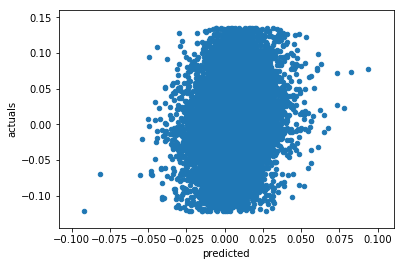

In [20]:
fitted_vals.plot(x='predicted',y='actuals',kind='scatter')
fitted_vals['error']=abs(fitted_vals['predicted']-fitted_vals['actuals'])
abse1=fitted_vals['error'].mean()
print (abse1)

## First attempt evaluation

From a visual inspection of the data it appears that for the features used, outliers may have played an important role in skewing the model's performance. There could also be problems with some of the location based variables or others being highly correlated. Next highly correlated features will be removed

In [ ]:
fit_minus_large_miss = fitted_vals[np.absolute(fitted_vals['predicted']-fitted_vals['actuals'])<=.5]
fit_minus_large_miss.plot(x='predicted',y='actuals',kind='scatter')

## Remove correlated features

While this was interesting, it is not used in the submitted model.

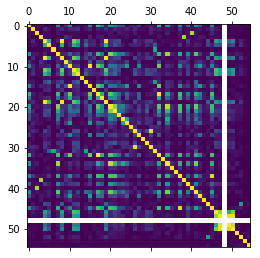

In [13]:
#only need absolute correlation
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 2000
corr_matrix=pca_frame.corr().abs()
plt.matshow(corr_matrix)

Because some of the features have no variation they will be droped, this are things such as year, since all observations are from the same year

C:\ProgramData\Anaconda5\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


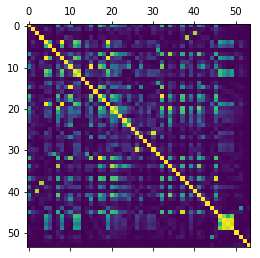

In [14]:
new_frame=pca_frame.loc[:, (pca_frame != pca_frame.ix[0]).any()] 
corr_matrix_2=new_frame.corr().abs()
plt.matshow(corr_matrix_2)

From this output we can see that some of the features have high correlation, the first of the highly correlated feature will be kept with the others dropped. What is concerning in this model is that the response value of the log error which is the value the model is attempting to predict is not correlated to any of the predictor values.

In [15]:
corr_matrix_2['logerror']

parcelid                        0.004837
airconditioningtypeid           0.006268
architecturalstyletypeid        0.001640
basementsqft                    0.009018
bathroomcnt                     0.027889
bedroomcnt                      0.025467
buildingclasstypeid             0.004824
buildingqualitytypeid           0.005069
calculatedbathnbr               0.027303
decktypeid                      0.000827
finishedfloor1squarefeet        0.012481
calculatedfinishedsquarefeet    0.039011
finishedsquarefeet12            0.039555
finishedsquarefeet13            0.003696
finishedsquarefeet15            0.000051
finishedsquarefeet50            0.012183
finishedsquarefeet6             0.010002
fips                            0.008363
fireplacecnt                    0.006357
fullbathcnt                     0.026777
garagecarcnt                    0.004616
garagetotalsqft                 0.008891
heatingorsystemtypeid           0.017002
latitude                        0.004915
longitude       

Next using recursive feature elimination the model will be re run, this will allow machine learning to select the best features. To begin I will use the top 10 features.



In [ ]:
rfe=RFE(forest_model,10)
rfe = rfe.fit(trainset,train_val)
print(rfe.support_)
print(rfe.ranking_)

In [ ]:
rfe_cols=list(trainset.columns[rfe.ranking_==1])
rfe_cols

From the RFE we now have the values most impactful, which from a primitative understanding of realestate make sense, as they have to do with the size, location, and tax value of the property. Now the model will be rerun with this reduced feature set.

In [ ]:
rfe_frame=pca_frame[rfe_cols]
trainset=rfe_frame[rand_data]
testset=rfe_frame[~rand_data]
forest_fit_rfe=forest_model.fit(trainset,train_val)
fitted_vals=pd.DataFrame(forest_fit_rfe.predict(testset))

In [ ]:
fitted_vals['actuals']=test_val
fitted_vals.columns=['predicted','actuals']
fitted_vals.plot(x='predicted',y='actuals',kind='scatter')
fitted_vals['error']=abs(fitted_vals['predicted']-fitted_vals['actuals'])
abse2=fitted_vals['error'].mean()
print (abse2)

Reducing the number of features did not improve the model, this would suggest that either too many features were removed or that even lesser features are critical to the success of the model. 

In [ ]:
print (datetime.now() - startTime)

In [ ]:
print('Best set so far ABSME =: %s' % (min(abse1,abse2)))

# Kaggle Competition
Lines below this are for specifically creating data for the kaggle competion, it will create an output file used to predict the sale price of each home in each month of Q4 for both 2016 and 2017   
At the time of writing this, the current ABSME winning values are approximately 0.064.
There will be repeated code as the data set will use all available values for traing (minus outliers) and trained on the full properties set

In [21]:
comp_properties=raw_properties
comp_id=raw_properties['parcelid']
#comp_properties=raw_properties.dropna(thresh=.1*len(raw_properties_combined),axis=1)
comp_properties=comp_properties.select_dtypes(include=[np.number])
comp_properties=comp_properties.apply(lambda x: x.fillna(-1),axis=0)


trainset_sub=pca_frame
trainset_sub=trainset_sub.drop('logerror',1)
train_val_sub=pca_frame['logerror']
#comp_properties=comp_properties[list(trainset_sub.columns)]

In [22]:
forest_model_submit=RandomForestRegressor(n_estimators=3000,
                                         bootstrap= True,
                                         max_depth= None,
                                         max_features= 8,
                                         min_samples_leaf= 11)

forest_fit_sub=forest_model_submit.fit(trainset_sub,train_val_sub)

#october
comp_properties['month']=10
fitted_vals_comp=pd.DataFrame(forest_fit_sub.predict(comp_properties))
fitted_vals_comp.columns=['201610']

#November
comp_properties['month']=11
november=pd.DataFrame(forest_fit_sub.predict(comp_properties))
#December
comp_properties['month']=12
december=pd.DataFrame(forest_fit_sub.predict(comp_properties))

In [23]:
submit_frame=pd.concat([raw_properties['parcelid'],fitted_vals_comp],axis=1)

In [24]:
submit_frame['201611']=november
submit_frame['201612']=december
submit_frame['201710']=fitted_vals_comp
submit_frame['201711']=november
submit_frame['201712']=december
list(submit_frame.columns.values)

['parcelid', '201610', '201611', '201612', '201710', '201711', '201712']

In [25]:
submit_frame.to_csv("C:/Users/Will/Documents/Regis/MSDS692/submission.csv",index=False, float_format='%.4f')

## Competition evaluation

current score: 0.0646174
bronze score <.0644  
Top place .0641376  
local mae to beat .0307027

In [1]:
10**.0641376

1.1591445563680982

In [169]:
topmodel=forest_fit_sub